In [1]:
#libraries
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
from models.unet import UNet
from models.skip import skip
import torch
import torch.optim
import time
from skimage.metrics import peak_signal_noise_ratio
from skimage.metrics import structural_similarity
from PIL import Image

from utils.demosaicing_utils import *
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor # for slow GPUs or no GPUs change to torch.FloatTensor

imsize =-1
PLOT = True
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0' # port of graphics card
torch.cuda.is_available()

True

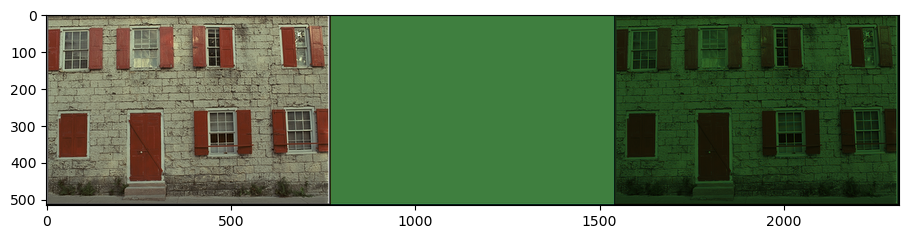

In [2]:
# set the image 
img_kodak = 'kodim01.png' # kodim02.png/kodim03.png/kodim04.png ...

img_path  = 'data/demosaicing/kodak_full/' + img_kodak
NET_TYPE = 'skip_depth4'

img_pil, img_np = get_image(img_path, imsize)


# uncomment to set the desired type of filter
# BAYER:
img_empty = empty_bayer_filter(img_np)

# XTRANS:
# img_empty = x_trans_filter(img_np)

# RANDOM:
# predefined random filter:
'''
filter = "random_filter_1.npy" # random_filter_2.npy/random_filter_doubleB_1.npy/random_filter_doubleG_1.npy
img_empty = np.load("data/demosaicing/filters/"+filter)
color, height, width = img_np.shape
if width == 512:
    img_empty = np.moveaxis(img_empty,0,-1)
    img_empty = np.rot90(img_empty)
    img_empty_ = np.moveaxis(img_empty,-1,0)
    img_empty = img_empty_.copy() 
'''
# totally random filter:
# img_empty =  random_filer(img_np)


img_input = img_empty*img_np

# plot ground truth, mask and input image
plot_image_grid([img_np, img_empty,img_input], 3, 8);

In [3]:
OPT_OVER = 'net'
OPTIMIZER = 'adam'
INPUT = 'noise'
# number of channels in the image
input_depth = 3

# set the network parameters
num_iter = 2000 # number of epochs (changable)
show_every = 100 # show image after x epochs (changable)
figsize = 8
reg_noise_std = 0.00 # default 0, potentially add additional noise
param_noise = True
if 'skip' in NET_TYPE:
    depth = int(NET_TYPE[-1])
    net = skip(input_depth,
        img_input.shape[0], 
        num_channels_down = [64,64,128,256,512],
        num_channels_up =    [64,64,128,256,512],
        num_channels_skip =  [0,0,0,0,0],
        filter_size_up = 3,
        filter_size_down = 3,
        filter_skip_size=1,
        pad='zero',
        upsample_mode='nearest',
        downsample_mode='stride',
        need1x1_up=True,
        need_sigmoid=True,
        need_bias=True, 
        act_fun='LeakyReLU').type(dtype)
    LR = 0.001


net = net.type(dtype)
net_input = get_noise(input_depth, INPUT, img_input.shape[1:]).type(dtype)

In [4]:
# Compute number of parameters
s  = sum(np.prod(list(p.size())) for p in net.parameters())
print ('Number of params: %d' % s)
mse = torch.nn.MSELoss().type(dtype)

# convert mask and input image to torch
img_input_var = np_to_torch(img_input).type(dtype)
empty_var = np_to_torch(img_empty).type(dtype)

i = 0
last_imgs = {}
def closure():
    global i
    global last_imgs
    # generate the starting random image
    if param_noise:
        for n in [x for x in net.parameters() if len(x.size()) == 4]:
            n = n + n.detach().clone().normal_() * n.std() / 50
    
    net_input = net_input_saved
    
    # add additional noise to image
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
        
        
    out = net(net_input)
    total_loss = mse(out *empty_var , img_input_var)
    total_loss.backward()
    
    # psnr between the ground truth and output (comment out to display psnr and ssim values of every epoch)
    '''
    psnr_ = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0])
    print ('Iteration %05d    Loss %f    PSNR %.4f' % (i, total_loss.item(), psnr_), '\r', end='')
    '''
    print ('Iteration %05d    Loss %f' % (i, total_loss.item()), '\r', end='')
    
    # save last images for averaging
    if i > num_iter-50:
        last_imgs[i] = out.detach().cpu().numpy()[0]
        
    # plot images (depends on the show_every parameter)    
    if  PLOT and i % show_every == 0:
        
        # comment out to calculate pnsr just for the plotted images
        
        psnr_ = peak_signal_noise_ratio(img_np, out.detach().cpu().numpy()[0])
        print ('Iteration %05d    Loss %f    PSNR %.4f' % (i, total_loss.item(), psnr_), '\r', end='')
        
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1
    return total_loss

net_input_saved = net_input.detach().clone()
noise = net_input.detach().clone()

# start optimization
p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

Number of params: 9069315
Starting optimization with ADAM


KeyboardInterrupt: 

In [ ]:
out_np = torch_to_np(net(net_input))

# plot the final image
plot_image_grid([img_np, out_np],2, factor=10);

# uncomment to save image at 2000 epochs
'''
im = Image.fromarray(np.moveaxis((out_np * 255).astype(np.uint8),0,-1))
im.save("2000_"+"_"+img_kodak)
'''

In [ ]:
# calculate psnr and ssim values of few last images
stats = []
psnrs = []
positions = []

for key, value in last_imgs.items():
    psnr_ = peak_signal_noise_ratio(img_np, value)
    stats.append([key,psnr_])

for item in stats:
    positions.append(item[0])
    psnrs.append(item[1])

# find the oracle image
for key,value in last_imgs.items():
    if key == positions[psnrs.index(max(psnrs))]:
        oracle_img = value

# calculate the average image of last 2, 40 and 50 epochs
averaged_50 = []
averaged_2 = []
averaged_40 = []
        
k = 0
while k != len(positions):
    temp_list = []
    count = 0
    for value in reversed(last_imgs.values()):
        temp_list.append(value)
        if count == k:
            break
        count+=1
    k+=1
    stacked = np.mean(np.stack(temp_list),axis=0)
    if k == 1:
        averaged_2 = stacked.copy()
    if k == 39:
        averaged_40 = stacked.copy()
    if k == 49:
        averaged_50 = stacked.copy()


In [ ]:
# show oracle image
plot_image_grid([oracle_img],1, factor=8);
print("oracle image")

# show averaged image of last 2 epochs
plot_image_grid([averaged_2],1, factor=8);
print("last 2 images averaged")

# show averaged image of last 40 epochs
plot_image_grid([averaged_40],1, factor=8);
print("last 40 images averaged")

# show averaged image of last 50 epochs
plot_image_grid([averaged_50],1, factor=8);
print("last 50 images averaged")

In [ ]:
#oracle image: (uncomment to save)
'''
im_oracle = Image.fromarray(np.moveaxis((oracle_img * 255).astype(np.uint8),0,-1))
im_oracle.save("oracle_"+img_kodak)
'''
#averaged images: (uncomment to save)
'''
avg_img_50 = averaged_50
im_averaged = Image.fromarray(np.moveaxis((avg_img_50 * 255).astype(np.uint8),0,-1))
im_averaged.save("averaged50_"+img_kodak)

avg_img_40 = averaged_40
im_averaged = Image.fromarray(np.moveaxis((avg_img_40 * 255).astype(np.uint8),0,-1))
im_averaged.save("averaged40_"+img_kodak)

avg_img_2 = averaged_2
im_averaged = Image.fromarray(np.moveaxis((avg_img_2 * 255).astype(np.uint8),0,-1))
im_averaged.save("averaged2_"+img_kodak)
'''